In [27]:
# ---------- CONFIG ----------
METHOD = 'STA'  
out_size = (64, 64)  # RF grid: 64x64 "sensors" (stimulus pixels); 128 is already crashing my system
n_subset = 2000 # random subset of >22k images in train set
shuffle_mapping = False # True mapping of MUA - image shown. acts as sanity check.
monkey = 'monkeyN'
E_SUBSET = None
if E_SUBSET is not None:
    assert E_SUBSET % 64 == 0
vlim = (-1e-3, 1e-3)

In [18]:
# ---------- IMPORTS ----------
import os
import numpy as np
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from os.path import join
# ---------- DIR ----------
wd = r"E:\radboud\Masters Thesis"
# image-side tree
image_side_dir = join(wd, 'data', 'source data', 'image data')
things_dir = join(image_side_dir, 'THINGS')
object_images_dir = os.path.join(things_dir,"images_THINGS", "object_images")
# ephys side tree
ephys_side_dir = join(wd, 'data', 'source data', 'neural data')
tvsd_dir = join(ephys_side_dir, 'TVSD')
log_path = join(tvsd_dir, monkey, '_logs')
image_MUA_mapping = join(log_path, 'things_imgs.mat') # mapping
normMUA_path = join(tvsd_dir, monkey, 'THINGS_normMUA.mat')
# derivatives tree
derivatives_ephys_dir = join(wd, 'derivatives', 'neural data', 'TVSD')
derivatives_rf_dir = join(derivatives_ephys_dir, monkey, 'ReceptiveFields')
# ana tree
ana_dir = join(wd, 'analysis', 'TVSD')
ana_monkey_dir = join(ana_dir, monkey)

In [19]:
# ---------- image side helpers ----------
def prepare_THINGS_objects(image_MUA_mapping, verbose = False):
    with h5py.File(image_MUA_mapping, "r") as f:
        train_group = f["train_imgs"]
        test_group  = f["test_imgs"]

        class_refs       = train_group["class"][()]        # (22248,)
        local_path_refs  = train_group["local_path"][()]   # (22248,)
        things_path_refs = train_group["things_path"][()]  # (22248,)

        print("class_refs shape:", class_refs.shape, "dtype:", class_refs.dtype)
        print("local_path_refs shape:", local_path_refs.shape, "dtype:", local_path_refs.dtype)
        print("things_path_refs shape:", things_path_refs.shape, "dtype:", things_path_refs.dtype)

        def unwrap_ref(ref):
            """
            Unwrap a reference that may be:
            - an h5py.Reference
            - a 0-d or 1-d numpy array containing a Reference
            and return a true h5py.Reference.
            """
            # Direct reference
            if isinstance(ref, h5py.Reference):
                return ref

            # 0-d / 1-d numpy array wrapping the reference
            arr = np.array(ref)
            if arr.dtype == object and arr.size > 0:
                inner = arr.ravel()[0]
                if isinstance(inner, h5py.Reference):
                    return inner
                # if it's still an array, recurse once
                if isinstance(inner, np.ndarray):
                    return unwrap_ref(inner)

            # Fallback: just try to treat ref as-is (will error if wrong)
            return ref

        def dset_to_str(dset):
            """
            Convert a dataset (often MATLAB char array) to a Python string.
            Handles:
            - bytes
            - numpy arrays of 'S'/'U'
            - numpy arrays of uint16/int16/int32 char codes
            """
            data = dset[()]  # grab contents

            # plain python types
            if isinstance(data, bytes):
                return data.decode("utf-8")
            if isinstance(data, str):
                return data

            arr = np.array(data)

            # string-like arrays
            if arr.dtype.kind in {"S", "U"}:
                flat = arr.ravel()
                parts = []
                for x in flat:
                    if isinstance(x, (bytes, bytearray)):
                        parts.append(x.decode("utf-8"))
                    else:
                        parts.append(str(x))
                return "".join(parts)

            # numeric char codes (MATLAB-style)
            if arr.dtype in (np.uint16, np.int16, np.int32, np.int64):
                chars = [chr(int(c)) for c in arr.ravel() if int(c) != 0]
                return "".join(chars)

            # last resort
            return str(arr)

        def refs_to_str_array(refs):
            strings = []
            for ref in refs:
                href = unwrap_ref(ref)
                dset = f[href]           # <--- this is where we previously passed an ndarray
                s = dset_to_str(dset)
                strings.append(s)
            return np.array(strings, dtype=object)

        train_class       = refs_to_str_array(class_refs)
        train_local_path  = refs_to_str_array(local_path_refs)
        train_things_path = refs_to_str_array(things_path_refs)
    if verbose:
        print('structure overview for index 0:')
        print("train_class[0]:      ", train_class[0])
        print("train_local_path[0]: ", train_local_path[0])
        print("train_things_path[0]:", train_things_path[0])
        print("n_train:", len(train_things_path))

    return train_class, train_local_path, train_things_path 

from PIL import Image
def load_image_downsample_gray(rel_path, root, size, verbose=False):
    """
    Load an image given a relative path, convert to grayscale, resize, and
    normalize to [0, 1].

    Args:
        rel_path: relative path to image (e.g. "aardvark/aardvark_01b.jpg")
        root: root directory where images live
        size: (H, W) tuple for resizing
        verbose: if True, print debug info

    Returns:
        arr: np.ndarray of shape (H, W), float32 in [0, 1]
    """
    img_path = os.path.join(root, rel_path)

    if verbose:
        print(f"[load_image] Loading: {img_path}")

    img = Image.open(img_path).convert("L")  # grayscale
    orig_w, orig_h = img.size

    if verbose:
        print(f"[load_image] Original size: {orig_w}x{orig_h} -> resizing to {size[0]}x{size[1]}")

    img = img.resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32)
    arr /= 255.0  # scale to [0,1]

    if verbose:
        print(f"[load_image] After resize: shape={arr.shape}, "
              f"min={arr.min():.3f}, max={arr.max():.3f}")

    return arr

In [20]:
# ---------- RF HELPERS ----------
def build_stimulus_and_response(
    image_paths,
    responses,
    root,
    size,
    idxs=None,
    verbose=True,
):
    """
    Build stimulus matrix X and response matrix R.

    Args:
        image_paths: array-like of length N_all with relative image paths.
        responses: np.ndarray of shape (N_all, E) with MUA responses.
        root: root directory for images.
        size: (H, W) for downsampled grayscale images.
        idxs: optional indices of images to use; if None, use all.
        verbose: if True, print debug info.

    Returns:
        X: np.ndarray of shape (N, D)  (N images, D pixels)
        R: np.ndarray of shape (N, E)  (N images, E electrodes)
        img_shape: tuple (H, W)
    """
    image_paths = np.asarray(image_paths)
    N_all = len(image_paths)

    if idxs is None:
        idxs = np.arange(N_all)
        if verbose:
            print(f"[build_SR] Using ALL {N_all} training images.")
    else:
        idxs = np.asarray(idxs)
        if verbose:
            print(f"[build_SR] Using subset of {len(idxs)} images out of {N_all} total.")

    N = len(idxs)
    E = responses.shape[1]

    # Load first image once to infer shape
    if verbose:
        print(f"[build_SR] Loading first example image at index {idxs[0]} for shape inference.")
    example_img = load_image_downsample_gray(image_paths[idxs[0]], root=root, size=size, verbose=verbose)
    H, W = example_img.shape
    D = H * W

    if verbose:
        print(f"[build_SR] Image shape: {H}x{W} -> D={D} pixels per image.")
        print(f"[build_SR] Number of electrodes E={E}")
        print(f"[build_SR] Allocating X with shape (N={N}, D={D}), R with shape (N={N}, E={E})")

    X = np.zeros((N, D), dtype=np.float32)
    R = np.zeros((N, E), dtype=np.float32)

    # Fill first row with example_img so we don't reload it
    X[0, :] = example_img.flatten()
    R[0, :] = responses[idxs[0], :]

    # Loop over remaining indices
    for k, i in enumerate(idxs[1:], start=1):
        if verbose and (k % max(1, N // 10) == 0):
            print(f"[build_SR] Processing image {k+1}/{N} (train index {i})")

        arr = load_image_downsample_gray(image_paths[i], root=root, size=size, verbose=False)
        X[k, :] = arr.flatten()
        R[k, :] = responses[i, :]

    if verbose:
        print(f"[build_SR] Done. X shape: {X.shape}, R shape: {R.shape}")
        print(f"[build_SR] X stats: mean={X.mean():.4f}, std={X.std():.4f}, "
              f"min={X.min():.4f}, max={X.max():.4f}")
        print(f"[build_SR] R stats: mean={R.mean():.4f}, std={R.std():.4f}, "
              f"min={R.min():.4f}, max={R.max():.4f}")

    return X, R, H, W

# Model RF centers via top-percentile centroid of absolute RF weights.
def rf_moments_ellipse(rf, use_abs=True, eps=1e-9):
    rf = np.asarray(rf)
    if use_abs:
        w = np.abs(rf)
    else:
        w = np.clip(rf, 0, None)
    w_sum = w.sum()
    if w_sum <= eps:
        return np.nan, np.nan, np.nan, np.nan

    H, W = rf.shape
    ys, xs = np.mgrid[0:H, 0:W]
    mx = (w * xs).sum() / w_sum
    my = (w * ys).sum() / w_sum
    vx = (w * (xs - mx) ** 2).sum() / w_sum
    vy = (w * (ys - my) ** 2).sum() / w_sum

    return mx, my, np.sqrt(vx + eps), np.sqrt(vy + eps)


def rf_center_top_percentile(rf, pct=2.0, use_abs=True, eps=1e-9):
    rf = np.asarray(rf)
    w = np.abs(rf) if use_abs else rf
    thr = np.nanpercentile(w, 100.0 - pct)
    mask = w >= thr
    if not np.any(mask):
        return np.nan, np.nan
    ys, xs = np.mgrid[0:w.shape[0], 0:w.shape[1]]
    w_sel = w * mask
    w_sum = w_sel.sum()
    if w_sum <= eps:
        return np.nan, np.nan
    mx = (w_sel * xs).sum() / w_sum
    my = (w_sel * ys).sum() / w_sum
    return float(mx), float(my)

def sta_params_from_rfs(RFs, use_abs=True):
    E, H, W = RFs.shape
    rfx = np.full(E, np.nan, dtype=float)
    rfy = np.full(E, np.nan, dtype=float)
    stdx = np.full(E, np.nan, dtype=float)
    stdy = np.full(E, np.nan, dtype=float)

    for i in range(E):
        mx, my, sx, sy = rf_moments_ellipse(RFs[i], use_abs=use_abs)
        rfx[i] = mx
        rfy[i] = my
        stdx[i] = sx
        stdy[i] = sy

    return {"RFX": rfx, "RFY": rfy, "STDX": stdx, "STDY": stdy}


def aggregate_params_per_array(params, n_arrays=16, n_per_array=64):
    rfx = params["RFX"].reshape(n_arrays, n_per_array)
    rfy = params["RFY"].reshape(n_arrays, n_per_array)
    stdx = params["STDX"].reshape(n_arrays, n_per_array)
    stdy = params["STDY"].reshape(n_arrays, n_per_array)

    return {
        "RFX": np.nanmean(rfx, axis=1),
        "RFY": np.nanmean(rfy, axis=1),
        "STDX": np.nanmean(stdx, axis=1),
        "STDY": np.nanmean(stdy, axis=1),
    }



def corr_rf(
    X,
    R,
    H,
    W,
    elec_indices=None,
    verbose=True,
):
    """
    Compute correlation-based RFs for one or more electrodes.

    Args:
        X: np.ndarray, shape (N, D)
           Stimulus matrix: N images, D pixels (flattened).
        R: np.ndarray, shape (N, E)
           Response matrix: N images, E electrodes.
        img_shape: (H, W) tuple, for reshaping RFs back to images.
        elec_indices: array-like of electrode indices to use.
                      If None, use all electrodes.
        shuffle: if True, shuffle rows of R (stimulus-response break) as control.
        rng: np.random.Generator or int or None.
             If provided, used for reproducible shuffling.
        verbose: if True, print debug info.

    Returns:
        RFs: np.ndarray, shape (E_sel, H, W)
        used_indices: np.ndarray, shape (E_sel,)
    """
    X = np.asarray(X, dtype=np.float32)
    R = np.asarray(R, dtype=np.float32)

    N, D = X.shape
    N2, E = R.shape
    assert N == N2, "X and R must have same number of rows (trials/images)"

    # Electrode subset
    if elec_indices is None:
        elec_indices = np.arange(E)
        if verbose:
            print(f"[corr_RF] Using ALL E={E} electrodes.")
    else:
        elec_indices = np.asarray(elec_indices)
        if verbose:
            print(f"[corr_RF] Using subset of {len(elec_indices)} electrodes.")

    # Center X and R once
    Xc = X - X.mean(axis=0, keepdims=True)   # (N, D)
    Rc = R - R.mean(axis=0, keepdims=True)   # (N, E)

    if verbose:
        print(f"[corr_RF] N={N} images, D={D} pixels, E={E} electrodes")
        print(f"[corr_RF] Computing pixel–electrode covariances ...")

    # Covariance: (D, E) = (D, N) @ (N, E)
    cov = (Xc.T @ Rc) / (N - 1)              # (D, E)

    # Std for pixels and electrodes
    std_x = Xc.std(axis=0, ddof=1)[:, None] + 1e-9   # (D, 1)
    std_y = Rc.std(axis=0, ddof=1)[None, :] + 1e-9   # (1, E)

    corr = cov / (std_x * std_y)                     # (D, E)

    # Select electrodes of interest
    corr_sel = corr[:, elec_indices]                 # (D, E_sel)
    E_sel = corr_sel.shape[1]

    # Reshape to RF maps: (E_sel, H, W)
    RFs = corr_sel.T.reshape(E_sel, H, W)

    if verbose:
        print(f"[corr_RF] Done. RFs shape: {RFs.shape}")
        print(f"[corr_RF] RF stats: mean={RFs.mean():.4f}, std={RFs.std():.4f}, "
              f"min={RFs.min():.4f}, max={RFs.max():.4f}")

    return RFs, elec_indices


In [21]:
# IMG 
train_class, train_local_path, train_things_path = prepare_THINGS_objects(image_MUA_mapping, verbose=False)
## class_refs shape: (22248, 1) dtype: object
## local_path_refs shape: (22248, 1) dtype: object
## things_path_refs shape: (22248, 1) dtype: object
## MUA
with h5py.File(normMUA_path, "r") as f:
    SNR           = np.array(f["SNR"])             # (4, 1024)
    SNR_max       = np.array(f["SNR_max"])         # (1024, 1)
    lats          = np.array(f["lats"])            # (4, 1024)
    oracle        = np.array(f["oracle"])          # (1024, 1)
    reliab        = np.array(f["reliab"])          # (435, 1024)
    tb            = np.array(f["tb"])              # (300, 1)
    test_MUA      = np.array(f["test_MUA"])        # (100, 1024)
    test_MUA_reps = np.array(f["test_MUA_reps"])   # (30, 100, 1024)
    train_MUA     = np.array(f["train_MUA"])       # (22248, 1024)

class_refs shape: (22248, 1) dtype: object
local_path_refs shape: (22248, 1) dtype: object
things_path_refs shape: (22248, 1) dtype: object


In [22]:
# PREPARE and ESTIMATE
# specify  images to use for RF estimation
n_total = len(train_things_path)
print(f"[MAIN] Total available training images: {n_total}")

# For speed, potentially use a random subset

idxs = np.random.choice(n_total, size=min(n_subset, n_total), replace=False)
print(f"[MAIN] Using {len(idxs)} images for RF estimation.")

# build X (stimuli) and R (responses)
X, R, H, W = build_stimulus_and_response(
    image_paths=train_things_path,
    responses=train_MUA,
    root=object_images_dir,
    size=out_size,
    idxs=None,   # or some subset
    verbose=False,
)
print(f"[MAIN] X shape: {X.shape}, R shape: {R.shape}, img_shape: {H, W}")
# --- Monkey N: which Utah array is in which area ---
# WARNING: order is a placeholder – adjust once you know the true array order from TVSD metadata.

if shuffle_mapping:
        N, D = X.shape
        E = R.shape[1]
        # get a random permutation of the N trials
        perm = np.random.permutation(N)        # shape: (N,)
        # shuffle responses relative to stimuli
        R = R[perm, :]    
        order = 'shuffled'
else:            
    order = 'ordered'




save_dir = join(derivatives_rf_dir, 'linear')
os.makedirs(save_dir, exist_ok=True)

data_fname = f"{monkey}_X_R_imgshape{len(idxs)}_{order}.npz"
save_path = os.path.join(save_dir, data_fname)

np.savez_compressed(save_path, X=X, R=R, H=H, W=W)
print(f"[SAVE] Saved stimulus-response data to: {save_path}")

[MAIN] Total available training images: 22248
[MAIN] Using 2000 images for RF estimation.
[MAIN] X shape: (22248, 4096), R shape: (22248, 1024), img_shape: (64, 64)
[SAVE] Saved stimulus-response data to: E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_X_R_imgshape2000_ordered.npz


In [23]:
## LOADING
# Construct load path
len_idxs = 22248
file_name = f"{monkey}_X_R_imgshape{len(idxs)}_{order}.npz"
load_path = os.path.join(derivatives_rf_dir, 'linear', file_name)

# Load .npz file
loaded = np.load(load_path)
X = loaded["X"]
R = loaded["R"]
H = int(loaded["H"])
W = int(loaded["W"])

print(f"[LOAD] Loaded X shape: {X.shape}, R shape: {R.shape}, img shape: {(H, W)} from {file_name}")

[LOAD] Loaded X shape: (22248, 4096), R shape: (22248, 1024), img shape: (64, 64) from monkeyN_X_R_imgshape2000_ordered.npz


In [24]:
# Fit model
RFs, used = corr_rf(X, R, H, W, elec_indices=None, verbose=False)
print(f"[MAIN] RFs shape: {RFs.shape}  (E_sel, H, W)")

[MAIN] RFs shape: (1024, 64, 64)  (E_sel, H, W)


[MAIN] Saved rf_per_array to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\STA\monkeyN_STA_RFs_true_order_rf_per_array.npy
[DIAG] Ellipse diameter (2*std_coeff*std) medians: 67.97006992664842 64.9358826232585
[MAIN] Saved params_per_array to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\STA\monkeyN_STA_RFs_params_true_order_rf_params_per_array.npz
[MAIN] Saved RF centers to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\STA\monkeyN_STA_RFs_params_true_order_rf_centers_per_array.csv


C:\Users\Radovan\AppData\Local\Temp\ipykernel_484\1046459654.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.95])


[plot_rf_grid_monkeyN] Saved PNG to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\STA\monkeyN_STA_RFs_true_order.png
[plot_rf_grid_monkeyN] Saved PDF to: E:\radboud\Masters Thesis\analysis\TVSD\monkeyN\Exploration\ReceptiveFields\STA\monkeyN_STA_RFs_true_order.pdf


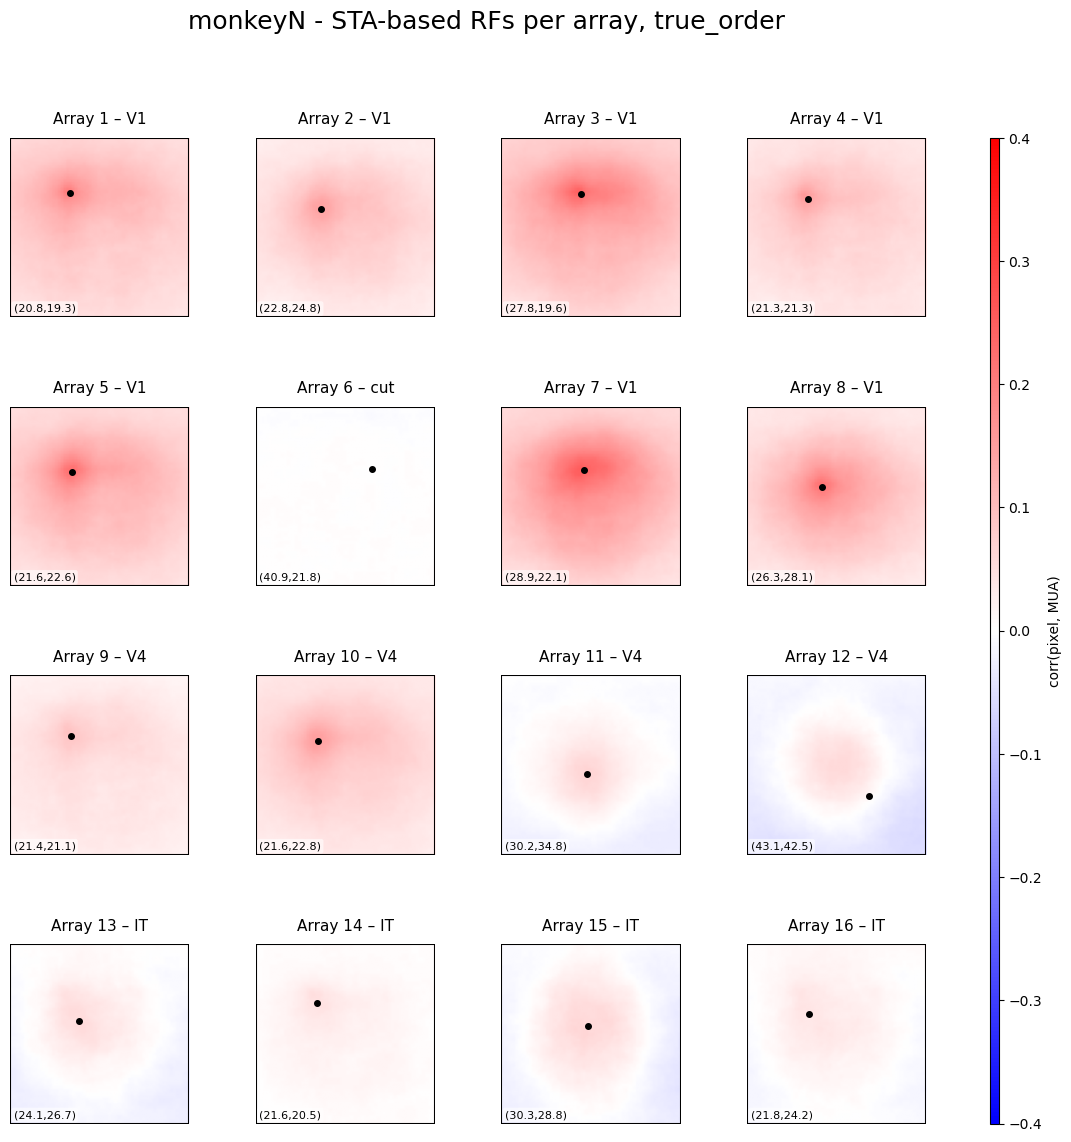

In [29]:
# Plotting
# array 
if monkey == 'monkeyN':
    # Nilson
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1',  7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
        6:  'cut'
    }
elif monkey == 'monkeyF':
    # Finch
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1', 6:  'V1', 7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
    }
# RFs: (1024, , W')
E, H, W = RFs.shape
assert E == 1024, "Expected 1024 electrodes for 16 Utah arrays"
# reshape to (16 arrays, 64 electrodes per array, H, W) and average over electrodes
rf_per_array = RFs.reshape(16, 64, H, W).mean(axis=1)   # (16, H, W)
# flip sign for modeling/plotting if desired
rf_per_array_model = -rf_per_array

# determine shuffling
if shuffle_mapping:
    shuffle_suffix = 'shuffled_order'
else:
    shuffle_suffix = 'true_order'


save_dir =  join(ana_monkey_dir, 'Exploration', 'ReceptiveFields', 'STA')
os.makedirs(save_dir, exist_ok=True)
basename = f'{monkey}_STA_RFs_{shuffle_suffix}'
rf_save_path = os.path.join(save_dir, f"{basename}_rf_per_array.npy")
np.save(rf_save_path, rf_per_array)
print(f"[MAIN] Saved rf_per_array to: {rf_save_path}")

# params per array estimated directly from array-averaged RFs
rfx_arr = np.full(16, np.nan, dtype=float)
rfy_arr = np.full(16, np.nan, dtype=float)
stdx_arr = np.full(16, np.nan, dtype=float)
stdy_arr = np.full(16, np.nan, dtype=float)
for i in range(16):
    mx, my = rf_center_top_percentile(rf_per_array_model[i], pct=2.0, use_abs=True)
    _, _, sx, sy = rf_moments_ellipse(rf_per_array_model[i], use_abs=True)
    rfx_arr[i] = mx
    rfy_arr[i] = my
    stdx_arr[i] = sx
    stdy_arr[i] = sy
params_per_array = {"RFX": rfx_arr, "RFY": rfy_arr, "STDX": stdx_arr, "STDY": stdy_arr}

# diagnostics for ellipse params (pixel units)
def qstats(x):
    return np.nanmin(x), np.nanmedian(x), np.nanmax(x)

valid = np.isfinite(stdx_arr) & np.isfinite(stdy_arr) & np.isfinite(rfx_arr) & np.isfinite(rfy_arr)
stdx_v = stdx_arr[valid]
stdy_v = stdy_arr[valid]
rfx_v = rfx_arr[valid]
rfy_v = rfy_arr[valid]
# print("[DIAG] RF size stats (stdx) min/med/max:", qstats(stdx_v))
# print("[DIAG] RF size stats (stdy) min/med/max:", qstats(stdy_v))
# print("[DIAG] RF center stats (rfx) min/med/max:", qstats(rfx_v))
# print("[DIAG] RF center stats (rfy) min/med/max:", qstats(rfy_v))
# print("[DIAG] Image size (H, W):", (H, W))

std_coeff = 2.0
print("[DIAG] Ellipse diameter (2*std_coeff*std) medians:",
      2 * std_coeff * np.nanmedian(stdx_v), 2 * std_coeff * np.nanmedian(stdy_v))
basename_params = f"{monkey}_{METHOD}_RFs_params_{shuffle_suffix}"
params_save_path = os.path.join(save_dir, f"{basename_params}_rf_params_per_array.npz")
np.savez(params_save_path, **params_per_array)
print(f"[MAIN] Saved params_per_array to: {params_save_path}")
# save focus coordinates per array (array_index, rfx, rfy)

coords = np.column_stack([np.arange(1, 17), rfx_arr, rfy_arr])
coords_path = os.path.join(save_dir, f"{basename_params}_rf_centers_per_array.csv")
np.savetxt(coords_path, coords, delimiter=",", header="array,rfx,rfy", comments="")
print(f"[MAIN] Saved RF centers to: {coords_path}")

# plot 16 averaged RFs (Utah arrays)

def plot_rf_grid_monkeyN(   
        rf_per_array, array2area,
        shuffle_suffix, vlim=(-0.5, 0.5),
        params_per_array=None,
        show_center_text=True,
        save_dir=None, basename="RFs_monkeyN",
        dpi=300
        ):
    """
    rf_per_array: np.ndarray, shape (16, H, W)
        RF map per Utah array for Monkey N.
        Assumed order: index 0 -> array 1, index 1 -> array 2, ..., index 15 -> array 16
    array2area: dict
        Mapping from 1-based array number -> area label, e.g.
        {1: 'V1', 2: 'V1', ..., 6: 'cut/unknown', ...}
    vlim: tuple (vmin, vmax) or None
        Color limits for imshow. If None, symmetric around 0 using global max.
    params_per_array: dict or None
        Optional center params with keys RFX/RFY (per array).
    """
    n_arrays, H, W = rf_per_array.shape

    n_cols = min(4, n_arrays)
    n_rows = int(np.ceil(n_arrays / n_cols))

    # Make figure a bit larger so titles have room
    fig = plt.figure(figsize=(3.2 * n_cols, 3.2 * n_rows))
    suptitle = f'{monkey} - STA-based RFs per array, {shuffle_suffix}'
    fig.suptitle(suptitle, fontsize=18)

    # rows x cols plus one column for colorbar
    gs = GridSpec(
        n_rows,
        n_cols + 1,  # extra column for colorbar
        width_ratios=[1] * n_cols + [0.05],
        wspace=0.4,
        hspace=0.5
    )

    # color limits
    if vlim is None:
        vmax = np.max(np.abs(rf_per_array))
        vmin = -vmax
    else:
        vmin, vmax = vlim

    for idx in range(n_arrays):
        r = idx // n_cols
        c = idx % n_cols
        ax = fig.add_subplot(gs[r, c])

        from matplotlib.patches import Rectangle

        rf = rf_per_array[idx]
        im = ax.imshow(rf, cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")

        # Add a black rectangle that exactly bounds the image
        rect = Rectangle(
            xy=(-0.5, -0.5),  # top-left corner (matches imshow default pixel centers)
            width=W, height=H,
            linewidth=1.5, edgecolor='black', facecolor='none'
        )
        ax.add_patch(rect)

        if params_per_array is not None:
            cx = params_per_array["RFX"][idx]
            cy = params_per_array["RFY"][idx]
            if np.isfinite([cx, cy]).all():
                ax.plot(cx, cy, marker="o", markersize=4, color="black")
                if show_center_text:
                    ax.text(
                        0.02, 0.02, f"({cx:.1f},{cy:.1f})",
                        transform=ax.transAxes, fontsize=8,
                        color="black", ha="left", va="bottom",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, ec="none"),
                    )

        array_num = idx + 1  # 1-based
        area = array2area.get(array_num, "unknown")
        ax.set_title(f"Array {array_num} – {area}", fontsize=11, pad=10)

        

    # dedicated colorbar axis on right-most column spanning all rows
    cax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("corr(pixel, MUA)")

    # tighten layout but leave room for suptitle
    plt.tight_layout(rect=[0, 0, 0.96, 0.95])
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        png_path = os.path.join(save_dir, f"{basename}.png")
        pdf_path = os.path.join(save_dir, f"{basename}.pdf")

        fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
        fig.savefig(pdf_path, dpi=dpi, bbox_inches="tight")
        print(f"[plot_rf_grid_monkeyN] Saved PNG to: {png_path}")
        print(f"[plot_rf_grid_monkeyN] Saved PDF to: {pdf_path}")
    plt.show()
    

from matplotlib.gridspec import GridSpec
plot_rf_grid_monkeyN(
        rf_per_array_model, array2area, shuffle_suffix=shuffle_suffix,
        vlim=(-0.4, 0.4),
        params_per_array=params_per_array,
        basename=basename, save_dir=save_dir)

